# Noodlification and unification on an example

In [1]:
import awalipy
import noodler

[Warning] The python module awalipy relies on compilation executed "on-the-fly" depending on the context (type of weights, of labels, etc.). As a result, the very first call to a given function in a given context may take up to 10 seconds. 


## query description
The string equation problem with variables $\mathsf{Var}$ is given by two components:
 1. equation $e$ of the form $e_l = e_r$ where $e_l, e_r \in \mathsf{Var}^+$.
 2. dictionary `constraints`${}\colon \mathsf{Var} \to \mathsf{RE(\mathsf{Var})}$. The regular expressions must be given as strings parsable by Awali, see [this guide](http://files.vaucanson-project.org/1.0/gs/RationalExpression.html) for more details.

In the running example, we use variables `x`,`y`, and `z` with alphabet `a,b,c`. In the following, we create an equation $zx = yz$ with regular constraints
* $L_x = \Sigma\{a\}\Sigma^+$,
* $L_y = \Sigma \Sigma^+$, and
* $L_z = \{b\}\Sigma^*$.

In [2]:
eq = noodler.StringEquation("zx", "yz")

alph = "abc"
Σ = f"({'+'.join(alph)})" # (a+b+c)

# Σ can be written in unicode by U+03A3. If you cannot
# write unicode symbols, use following variables instead.
Sigma_exp = Σ
Sigma_plus = f"{Σ+Σ}*"

constraints = {
    "x" : f"{Σ}(a){Σ}{Σ}*",
    "y" : f"{Σ}{Σ}{Σ}*",
    "z" : f"(b){Σ}*"
}
for var in constraints:
    print(f"{var}: {constraints[var]}")

x: (a+b+c)(a)(a+b+c)(a+b+c)*
y: (a+b+c)(a+b+c)(a+b+c)*
z: (b)(a+b+c)*


In [3]:
aut_constraints = {var : awalipy.RatExp(c, alphabet=alph).exp_to_aut() for var, c in constraints.items()}

query = noodler.AutSingleSEQuery(eq, aut_constraints)
print(query.eq)
query.show_constraints()

zx = yz


## Representation by segment automata

Our algorithm works with _segment automata_. Automata, which can be split to segments by removing ε-transitions. The idea is, roughly, that a segment automaton represents a concatenation of automata for a side of the input equation. The package `Noodler` contains function `chain_automata` that creates a segment automaton from a list of automata.

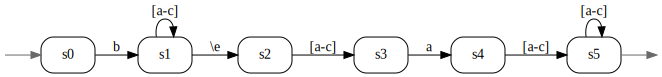

In [4]:
auts_l = query.automata_for_side("left")
seg_l = noodler.chain_automata(auts_l)
seg_l.display()

## The algo based on segment automata

![algo](img/string_algo.png)

## Make the pastry and make and noodles
Lines 2 and 3 of the algorithm basically make a product (pastry) of the segment automata for the two sides, and create **noodles** from this product. 

### Pastry a.k.a product
The product is of a special kind: left-ε-transition-preserving. Basically, we create a minimal automaton (`aut_r`) for the language of the right side of the equation and make a product with the segment automaton for the left side (`seg_l`). The result is, again, a segment automaton (with the same number of segments as `seg_l`).

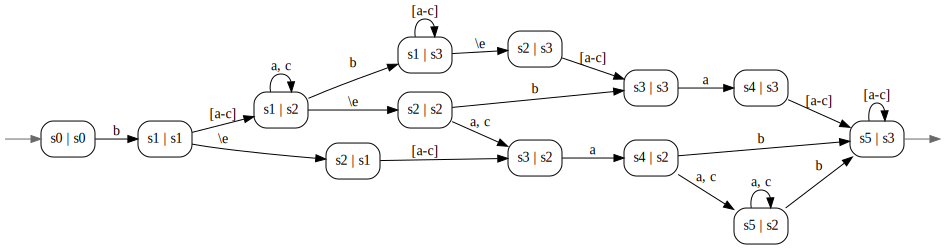

In [5]:
# Concatenate automaton for the right hand side
aut_r = noodler.multiop(query.automata_for_side("right"), awalipy.concatenate)
aut_r = aut_r.minimal_automaton()
# Make ε-preserving product
product = noodler.eps_preserving_product(seg_l, aut_r, history=True)
product.display()

We can split the segment automaton to segments again :-)

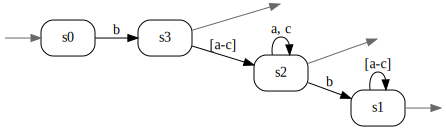

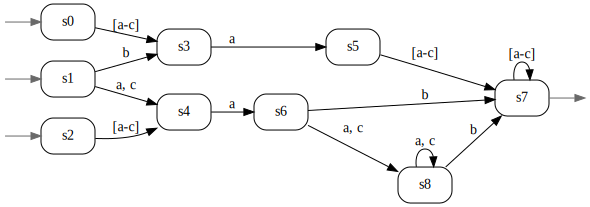

In [6]:
for aut in noodler.split_segment_aut(product):
    aut.display()

### Noodlify!
A noodle is a part of the pastry where we keep only one ε-transition between each two consecutive segments. The task of noodlify is to create all meaningfull noodles. For a segment automaton with $k+1$ segments and at most $t$ ε-transitions between each two consecutive segments, we have at most $k \times t$ noodles.

Let $T_1, T_2, \ldots T_k$ be the sets of ε-transitions between segments: 
 * $\mathrm{seg}_1 \xrightarrow{T_1} \mathrm{seg}_2$
 * $\mathrm{seg}_2 \xrightarrow{T_2} \mathrm{seg}_3$
 * ...
 * $\mathrm{seg}_k \xrightarrow{T_k} \mathrm{seg}_k$
 
Then the set of noodles is basically defined by the cartesian product $T_1 \times T_2 \times \ldots T_k$. Of course, we return only those noodles whose language is non-empty.

We have 3 noodles


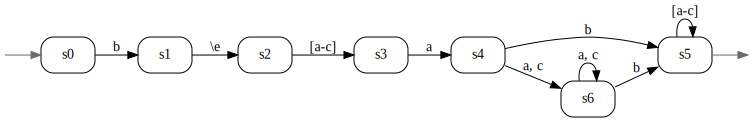

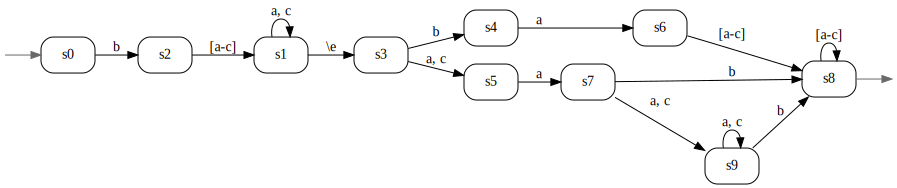

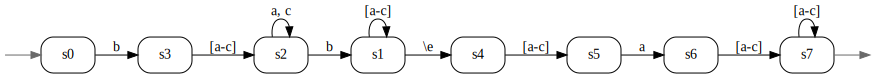

In [7]:
noodles = noodler.noodlify(product)
print(f"We have {len(noodles)} noodles")
for noodle in noodles:
    noodle.display()

## Process the noodle
Now for each noodle and the original right-side segment automaton we run **unification** (line 6). Each noodle itself is a segment automaton again. Unification ensures in these two automata that the segments that correspond to the same variable of the equation represent the same language. So we split the segment automaton of the noodle into segments and unify them with the segments of the right-hand side. The unification function takes the original equation, and list of automata for each side.

In [8]:
auts_r = query.automata_for_side("right")
for noodle in noodles:
    print("="*20)
    auts_l = noodler.split_segment_aut(noodle)
    noodle_sys = noodler.create_unified_query(query.eq,
                                               auts_l,
                                               auts_r)
    noodle_sys.show_constraints()
    print(f"Balanced? {noodle_sys.is_balanced()}")

Balanced? False


Balanced? False


Balanced? False
